In [1]:
import pandas as pd
import numpy as np
import prepare
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy.stats as stats
from sklearn.model_selection import train_test_split


# modeling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import warnings
warnings.filterwarnings("ignore")

In [2]:
from acquire import get_zillow_data

In [3]:
# acquire the zillow dataset that we are using
df = get_zillow_data()
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,yearbuilt,taxvaluedollarcnt,taxamount,propertylandusetypeid
0,11721753,2.0,3.0,1316.0,6037.0,1923.0,205123.0,2627.48,261.0
1,11289917,2.0,3.0,1458.0,6037.0,1970.0,136104.0,2319.90,261.0
2,11705026,1.0,2.0,1421.0,6037.0,1911.0,35606.0,543.69,261.0
3,14269464,3.0,4.0,2541.0,6059.0,2003.0,880456.0,9819.72,261.0
4,11446756,2.0,3.0,1491.0,6037.0,1955.0,107110.0,1399.27,261.0


In [4]:
df.shape

(28186, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28186 entries, 0 to 28185
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28186 non-null  int64  
 1   bathroomcnt                   28186 non-null  float64
 2   bedroomcnt                    28186 non-null  float64
 3   calculatedfinishedsquarefeet  28118 non-null  float64
 4   fips                          28186 non-null  float64
 5   yearbuilt                     28094 non-null  float64
 6   taxvaluedollarcnt             28185 non-null  float64
 7   taxamount                     28185 non-null  float64
 8   propertylandusetypeid         28186 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


## PREPARE

In [6]:
#check for null values
df.isnull().sum()

parcelid                         0
bathroomcnt                      0
bedroomcnt                       0
calculatedfinishedsquarefeet    68
fips                             0
yearbuilt                       92
taxvaluedollarcnt                1
taxamount                        1
propertylandusetypeid            0
dtype: int64

In [7]:
#drop nulls
df = df.dropna()

In [8]:
#verify nulls were dropped
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
yearbuilt                       0
taxvaluedollarcnt               0
taxamount                       0
propertylandusetypeid           0
dtype: int64

In [9]:
df['parcelid'].duplicated().value_counts()

False    28065
True        24
Name: parcelid, dtype: int64

In [10]:
df.drop_duplicates(subset = ['parcelid'], inplace=True)

In [11]:
df['parcelid'].duplicated().value_counts()

False    28065
Name: parcelid, dtype: int64

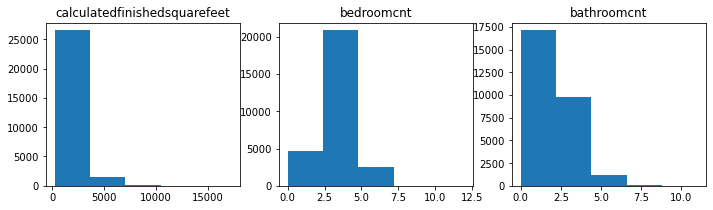

In [12]:
# Plot the distributions
plt.figure(figsize=(16, 3))

# List of columns
cols = ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

#### You will need to figure out which field gives you the annual tax amount for the property in order to calculate the tax rate. Using the property's assessed value (taxvaluedollarcnt) and the amount they pay each year (<field name>) to compute tax rate.

In [13]:
df['tax_rate'] =df['taxamount']/  df['taxvaluedollarcnt']

#### You will want to do some data validation or QA (quality assurance) to be sure the data you gather is what you think it is.



In [14]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,yearbuilt,taxvaluedollarcnt,taxamount,propertylandusetypeid,tax_rate
0,11721753,2.0,3.0,1316.0,6037.0,1923.0,205123.0,2627.48,261.0,0.012809
1,11289917,2.0,3.0,1458.0,6037.0,1970.0,136104.0,2319.90,261.0,0.017045
2,11705026,1.0,2.0,1421.0,6037.0,1911.0,35606.0,543.69,261.0,0.015270
3,14269464,3.0,4.0,2541.0,6059.0,2003.0,880456.0,9819.72,261.0,0.011153
4,11446756,2.0,3.0,1491.0,6037.0,1955.0,107110.0,1399.27,261.0,0.013064


In [15]:
df.rename(columns={'bathroomcnt': 'bath', 
                     'bedroomcnt': 'bed',
                     'calculatedfinishedsquarefeet': 'sqrft',
                     'fips': 'county',
                     'taxvaluedollarcnt': 'taxval',
                     'taxamount': 'taxamt'}, inplace=True
            )

In [16]:
df.head(3)

,parcelid,bath,bed,sqrft,county,yearbuilt,taxval,taxamt,propertylandusetypeid,tax_rate
0,11721753,2.0,3.0,1316.0,6037.0,1923.0,205123.0,2627.48,261.0,0.012809
1,11289917,2.0,3.0,1458.0,6037.0,1970.0,136104.0,2319.90,261.0,0.017045
2,11705026,1.0,2.0,1421.0,6037.0,1911.0,35606.0,543.69,261.0,0.015270


In [17]:
df['propertylandusetypeid'].value_counts()

261.0    28026
263.0       28
260.0        8
264.0        3
Name: propertylandusetypeid, dtype: int64

In [18]:
## we would use this if we are going to use minmaxscaler
## prepare.outlier_bound_calculation(df, bathroomcnt)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28065 entries, 0 to 28184
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   parcelid               28065 non-null  int64  
 1   bath                   28065 non-null  float64
 2   bed                    28065 non-null  float64
 3   sqrft                  28065 non-null  float64
 4   county                 28065 non-null  float64
 5   yearbuilt              28065 non-null  float64
 6   taxval                 28065 non-null  float64
 7   taxamt                 28065 non-null  float64
 8   propertylandusetypeid  28065 non-null  float64
 9   tax_rate               28065 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.4 MB


In [20]:
def outlier_bound_calculation(df, variable):
    '''
    calcualtes the lower and upper bound to locate outliers in variables
    '''
    quartile1, quartile3 = np.percentile(df[variable], [25,75])
    IQR_value = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * IQR_value)
    upper_bound = quartile3 + (1.5 * IQR_value)
    '''
    returns the lowerbound and upperbound values
    '''
    return print(f'For {variable} the lower bound is {lower_bound} and  upper bound is {upper_bound}')

In [21]:
outlier_bound_calculation(df, 'bath')

For bath the lower bound is 0.5 and  upper bound is 4.5


In [22]:
df= df[df.bath > 0.5]
df= df[df.bath < 4.5]

In [23]:
outlier_bound_calculation(df, 'bed')

For bed the lower bound is 1.5 and  upper bound is 5.5


In [24]:
df= df[df.bed > 1.5]
df= df[df.bed < 5.5]

In [25]:
outlier_bound_calculation(df, 'sqrft')

For sqrft the lower bound is -118.0 and  upper bound is 3586.0


In [26]:
df= df[df.sqrft > -118.0]
df= df[df.sqrft < 3586.0]

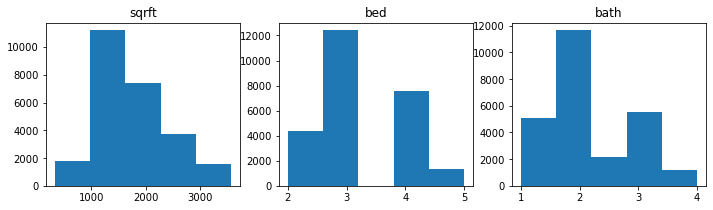

In [27]:
# Plot the distributions
plt.figure(figsize=(16, 3))

# List of columns
cols = ['sqrft', 'bed', 'bath']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

In [28]:
# Scale everything else through MinMax

In [29]:
df.head(3)

,parcelid,bath,bed,sqrft,county,yearbuilt,taxval,taxamt,propertylandusetypeid,tax_rate
0,11721753,2.0,3.0,1316.0,6037.0,1923.0,205123.0,2627.48,261.0,0.012809
1,11289917,2.0,3.0,1458.0,6037.0,1970.0,136104.0,2319.90,261.0,0.017045
2,11705026,1.0,2.0,1421.0,6037.0,1911.0,35606.0,543.69,261.0,0.015270


In [30]:
def split_continuous(df):
    '''
    Takes in a df
    Returns train, validate, and test DataFrames
    '''
    # Create train_validate and test datasets
    train_validate, test = train_test_split(df, 
                                        test_size=.2, 
                                        random_state=123)
    # Create train and validate datsets
    train, validate = train_test_split(train_validate, 
                                   test_size=.3, 
                                   random_state=123)
    return train, validate, test

In [31]:
# split the data in train, validate and test
train, test = train_test_split(df, test_size = 0.2, random_state = 1349)
train, validate = train_test_split(train, test_size = 0.25, random_state = 1349)

In [32]:
#check the shape
train.shape, validate.shape, test.shape

((15388, 10), (5130, 10), (5130, 10))

In [33]:
train.head()

,parcelid,bath,bed,sqrft,county,yearbuilt,taxval,taxamt,propertylandusetypeid,tax_rate
5959,11324084,3.0,3.0,2544.0,6037.0,2005.0,228849.0,5519.18,261.0,0.024117
21006,12797236,1.0,3.0,1176.0,6037.0,1952.0,215183.0,2818.59,261.0,0.013099
14071,12319787,2.0,3.0,1690.0,6037.0,1975.0,100911.0,1426.08,261.0,0.014132
23145,11682794,3.0,3.0,3006.0,6037.0,1974.0,6523866.0,74726.31,261.0,0.011454
16963,12272985,1.0,2.0,634.0,6037.0,1949.0,30371.0,933.69,261.0,0.030743


In [34]:
def split_target(train, validate, test, taxval):
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=['taxval'])
    y_train = train['taxval']

    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=['taxval'])
    y_validate = validate['taxval']

    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=['taxval'])
    y_test = test['taxval']

    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [35]:
X_train, y_train, X_validate, y_validate, X_test, y_test=split_target(train, validate, test, 'taxval')

In [36]:
numeric_cols = ['sqrft', 'taxamt']

In [37]:
def min_max_scale(X_train, X_validate, X_test, numeric_cols):
    """
    this function takes in 3 dataframes with the same columns,
    a list of numeric column names (because the scaler can only work with numeric columns),
    and fits a min-max scaler to the first dataframe and transforms all
    3 dataframes using that scaler.
    it returns 3 dataframes with the same column names and scaled values.
    """
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).

    scaler = MinMaxScaler(copy=True).fit(X_train[numeric_cols])

    # scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train.
    #
    X_train_scaled_array = scaler.transform(X_train[numeric_cols])
    X_validate_scaled_array = scaler.transform(X_validate[numeric_cols])
    X_test_scaled_array = scaler.transform(X_test[numeric_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=numeric_cols).set_index(
        [X_train.index.values]
    )

    X_validate_scaled = pd.DataFrame(
        X_validate_scaled_array, columns=numeric_cols
    ).set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=numeric_cols).set_index(
        [X_test.index.values]
    )

    return X_train_scaled, X_validate_scaled, X_test_scaled

In [38]:
X_train_scaled, X_validate_scaled, X_test_scaled= min_max_scale(X_train, X_validate, X_test, numeric_cols)

In [39]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((15388, 2), (5130, 2), (5130, 2))

In [40]:
X_train_scaled

,sqrft,taxamt
5959,0.680995,0.057207
21006,0.260976,0.028952
14071,0.418790,0.014384
23145,0.822843,0.781267
16963,0.094566,0.009232
...,...,...
27776,0.333129,0.074550
4813,0.678539,0.040647
25688,0.198342,0.052974
995,0.210623,0.032720


### Explore

In [41]:
# a lot of these functions already came from the prepare.py file kbest, rfe

In [42]:
df_corr = train.drop(columns=['parcelid', 'propertylandusetypeid'])
df_corr

,bath,bed,sqrft,county,yearbuilt,taxval,taxamt,tax_rate
5959,3.0,3.0,2544.0,6037.0,2005.0,228849.0,5519.18,0.024117
21006,1.0,3.0,1176.0,6037.0,1952.0,215183.0,2818.59,0.013099
14071,2.0,3.0,1690.0,6037.0,1975.0,100911.0,1426.08,0.014132
23145,3.0,3.0,3006.0,6037.0,1974.0,6523866.0,74726.31,0.011454
16963,1.0,2.0,634.0,6037.0,1949.0,30371.0,933.69,0.030743
...,...,...,...,...,...,...,...,...
27776,2.0,2.0,1411.0,6037.0,1962.0,580623.0,7176.89,0.012361
4813,2.5,5.0,2536.0,6059.0,1975.0,354581.0,3936.38,0.011101
25688,1.0,3.0,972.0,6037.0,1952.0,425000.0,5114.59,0.012034
995,1.0,3.0,1012.0,6037.0,1944.0,253162.0,3178.72,0.012556


### KBest

In [43]:
f_selector = SelectKBest(score_func=f_regression, k=2)
f_selector.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7f8e7b51d3a0>)

In [44]:
mask = f_selector.get_support()
X_train_scaled.columns[mask]

Index(['sqrft', 'taxamt'], dtype='object')

In [45]:
X_train_kbest = f_selector.transform(X_train_scaled)
model = LinearRegression().fit(X_train_kbest, y_train)

In [46]:
# statistical testing

### T-Test

- $H_o$ There is no correlation between sqft and tax value 
- $H_a$ There is a correlation between sqft and tax value

In [47]:
# set alpha
alpha = 0.05

In [48]:
df.head(3)

,parcelid,bath,bed,sqrft,county,yearbuilt,taxval,taxamt,propertylandusetypeid,tax_rate
0,11721753,2.0,3.0,1316.0,6037.0,1923.0,205123.0,2627.48,261.0,0.012809
1,11289917,2.0,3.0,1458.0,6037.0,1970.0,136104.0,2319.90,261.0,0.017045
2,11705026,1.0,2.0,1421.0,6037.0,1911.0,35606.0,543.69,261.0,0.015270


In [49]:
t, p = stats.ttest_ind(train.taxval,train.sqrft, equal_var=False)

In [50]:
# check if the p is less than the alpha
p<alpha

True

In [51]:
#Since p is less than our alpha, we reject the null hypothesis. 

### Correlation Test

- $H_o$ There is no correlation between bedroom count and tax value
- $H_a$ There is a correlation between bedroom count and tax value

In [52]:
x = df['taxval']
y = df['bed']

In [53]:
r, p = stats.pearsonr(x, y)

In [54]:
p<alpha

True

In [55]:
#Since p is less than our alpha, we reject the null hypothesis. 

In [56]:
x2 = df['taxval']
y2 = df['bath']

In [57]:
r, p = stats.pearsonr(x2, y2)

In [58]:
p<alpha

True

In [59]:
#Since p is less than our alpha, we reject the null hypothesis. 

In [60]:
# prove mvp is correlated to price

In [67]:
# key drivers - MVP


# bed, bath, sqft

#### Since we reject the null hypothesis on bedroom count, bathroom count and tax value, they will be the MVP

In [68]:
df.head(3)

,parcelid,bath,bed,sqrft,county,yearbuilt,taxval,taxamt,propertylandusetypeid,tax_rate
0,11721753,2.0,3.0,1316.0,6037.0,1923.0,205123.0,2627.48,261.0,0.012809
1,11289917,2.0,3.0,1458.0,6037.0,1970.0,136104.0,2319.90,261.0,0.017045
2,11705026,1.0,2.0,1421.0,6037.0,1911.0,35606.0,543.69,261.0,0.015270


### Modeling

In [69]:
# start running models - Linear regression, polynomial regression(skewed data, curved data).....  (depending on what your data looks like)

Find your baseline

In [70]:
y_train.head()

5959      228849.0
21006     215183.0
14071     100911.0
23145    6523866.0
16963      30371.0
Name: taxval, dtype: float64

In [71]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict taxval_pred_mean
taxval_pred_mean = y_train.taxval.mean()
y_train['taxval_pred_mean'] = taxval_pred_mean
y_validate['taxval_pred_mean'] = taxval_pred_mean

# 2. compute taxval_pred_median
taxval_pred_median = y_train.taxval.median()
y_train['taxval_pred_median'] = taxval_pred_median
y_validate['taxval_pred_median'] = taxval_pred_median

# 3. RMSE of taxval_pred_mean
rmse_train = mean_squared_error(y_train.taxval, y_train.taxval_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.taxval, y_validate.taxval_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of taxval_pred_median
# rmse_train = mean_squared_error(y_train.taxval, y_train.taxval_pred_median) ** .5
# rmse_validate = mean_squared_error(y_validate.taxval, y_validate.taxval_pred_median) ** .5
# print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
#       "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  406798.22 
Validate/Out-of-Sample:  393704.96


In [72]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.taxval, y_validate.taxval_pred_mean)}])

In [73]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,393704.956626,0.0


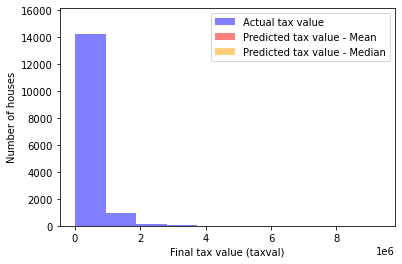

In [74]:
plt.hist(y_train.taxval, color='blue', alpha=.5, label="Actual tax value")
plt.hist(y_train.taxval_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted tax value - Mean")
plt.hist(y_train.taxval_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted tax value - Median")
plt.xlabel("Final tax value (taxval)")
plt.ylabel("Number of houses")
plt.legend()
plt.show()

#### LinearRegression

In [75]:
lm = LinearRegression(normalize=True)
# fit the thing
# 
lm.fit(X_train, y_train.taxval)

# predict train
# 
# use the thing!
# 
y_train['taxval_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxval, y_train.taxval_pred_lm) ** (1/2)
# predict validate
y_validate['taxval_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxval, y_validate.taxval_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  62862.052375919746 
Validation/Out-of-Sample:  81577.26084525236


In [76]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.taxval, y_validate.taxval_pred_lm)}, ignore_index=True)

In [77]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,393704.956626,0.000000
1,OLS lm,81577.260845,0.957082


In [78]:
rmse_validate

81577.26084525236

In [45]:
# run best model on test

In [46]:
# then powerpoint

In [47]:
# when you plot, use a sample first because it may be too large and overload the computer